In [1]:
import os, sys, uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import HomeMade as hm
import seaborn as sb
from iminuit import Minuit
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import shap
import dill
from AppStatFunctions import Chi2Regression,UnbinnedLH, BinnedLH, add_text_to_ax, nice_string_output

In [305]:
Nmax=2.4e6
uncorrelated=['v0_chi2', 'v0_px1', 'v0_phi1', 'v0_py1', 'v0_py', 'v0_py2', 'v0_phi2', 'v0_px2', 'v0_px', 'cosTheta', 'a0xy', 'a0', 'v0_y', 'v0_x', 'v0_rxyErr', 'v0_z', 'pv0_z', 'pv0_y', 'ntrk_pv0', 'pv0_x']

In [307]:
N = 1e5
if N>Nmax:
    N=Nmax
    print('Maxed out')

all_features = "v0_ks_mass v0_ks_massErr pv0_x pv0_y pv0_z a0xy a0 a0z cosTheta v0_chi2 \
v0_x v0_y v0_z v0_rxy v0_rxyErr v0_px v0_py v0_pz v0_pt v0_p \
v0_ptErr \
v0_px1 v0_py1 v0_pz1 v0_pt1 \
v0_p1 v0_px2 v0_py2 v0_pz2 v0_pt2 v0_p2 v0_phi1 v0_theta1 \
v0_qOverP1 v0_phi2 v0_theta2 v0_qOverP2 alpha calpha epsilon1 \
epsilon2 Alpha pL1 pL2 pT thetastar rapidity_ks ntrk_pv0 pseudorapidity".split(" ")

path = "../../data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(all_features, entrystop = N)

path = "../../data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
file = uproot.open(path)
mc = file['tree'].pandas.df(all_features + ['trueKs'], entrystop = N)

data = data.loc[(data.v0_ks_mass > 400) & (data.v0_ks_mass < 600)]
train_data = data.sample(frac=0.7)
test_data = data[~data.index.isin(train_data.index)]

mc = mc.loc[(mc.v0_ks_mass > 400) & (mc.v0_ks_mass < 600)]
train_mc = mc.sample(frac=0.7)
test_mc = mc[~mc.index.isin(train_mc.index)]

In [181]:
from scipy.optimize import curve_fit
from scipy.stats import norm, chi2

def fit_mass_double(xs, vals, errs, ax = None, guesses_bkgr = [0, 0, -10, 2000], guesses_sig = [498, 6, 17000], sigratio=2, depth=50, plot=True):
    """double gauss fit with mu_1=mu_2, with polynomial backgground fit: Give bincenter, vals, sig, a figure to plot, otherwise 
    it plots itself, guesses for both gaussian and background. Update might follow with updated estimation of guesses, but for
    the time being we use optimize.curvefit to give guesses for minuit
    
    Returns fig, ax, the full Minuit object, background amount and signal amount:
    """
    mask=vals>0
    xs, vals, errs=xs[mask], vals[mask], errs[mask]
    #look into automatizing the guesses
    mu, sigma, N = guesses_sig
    #Make a 5 sigma cut so only background is here
    bkgr_mask = (xs < mu-4*sigma) | (xs > mu+4*sigma)

    guesses_bkgr[-1] = (vals[np.argmin(xs-mu)]+vals[0]+vals[-1])/4
    if not ax and plot:
        fig, ax = plt.subplots(figsize = (16, 10), ncols = 2)
        ax_sig = ax[1]
        ax_all = ax[0]
        ax_all.plot(xs, vals, 'r.')
        ax_all.errorbar(xs, vals, errs, color = 'k', elinewidth = 1, capsize = 2, ls = 'none')

    def background_fit(x, a, b, c, d):
        return a * (x-mu) ** 3 + b * (x-mu) ** 2 + c * (x-mu) + d
    
    # The signal fit  Here gauss
    def sig1(x, mean, sig, size):
        return size*norm.pdf(x, mean, sig)
    
    def sig2(x, mean, sig, size):
        return size*norm.pdf(x, mean, sig)
    
    # The full fit
    def full_fit(x, mean, sig, size, f, sigmp, a, b, c, d):
        return background_fit(x, a, b, c, d) + f*sig1(x, mean, sig, size) + (1-f)*sig2(x, mean, sigmp*sig, size)
    
     # Background fit under here
    if sum(vals[bkgr_mask])==0:
        def background_fit(xs, a, b, c, d):
            return 0*xs
        b1, b2, b3, b4=0,0,0,0
    else:
        vals_b, cov_b = curve_fit(background_fit, xs[bkgr_mask], vals[bkgr_mask], p0 = guesses_bkgr)
        b1, b2, b3, b4 = vals_b
        bkgr_chi2 = Chi2Regression(background_fit, xs[bkgr_mask], vals[bkgr_mask], errs[bkgr_mask])
        bkgr_min  = Minuit(bkgr_chi2, pedantic = False, a = b1, b = b2, c = b3, d = b4)
        bkgr_min.migrad()
        counter = 0
        bkgr_min
        while not bkgr_min.valid and counter<depth:
            bkgr_min.migrad()
            counter += 1
        if not bkgr_min.valid: print("No background valid minimum found!")

        #Save guesses 
        b1, b2, b3, b4 = bkgr_min.args
    N=(max(vals[~bkgr_mask])- background_fit(xs[np.argmax(xs[~bkgr_mask])], b1, b2, b3, b4))*30
    # Full fit
    full_chi2 = Chi2Regression(full_fit, xs, vals, errs)
    full_min  = Minuit(full_chi2, pedantic = False, a = b1, b = b2, c = b3, d = b4, \
                       mean = mu, sig = sigma, size = N, f = 0.5, sigmp = sigratio)

    full_min.migrad()
    counter = 0
    while not full_min.valid and counter<5*depth:
        full_min = Minuit(full_chi2, pedantic = False, a = b1, b = b2, c = b3, d = b4, \
        mean = mu, sig = sigma*np.random.uniform(0.8,1.2), size = N*np.random.uniform(0.8,1.2),\
        f = 0.5*np.random.uniform(0.8,1.2), sigmp = sigratio*np.random.uniform(0.8,1.2))
        full_min.migrad()
        counter += 1
    if not full_min.valid: print(f"No valid double gaussian minimum found after {counter} tries!")

    mean, sig, size, f, sigmp, b1, b2, b3, b4 = full_min.args

    sig_amount = np.sum(abs(f*sig1(xs, mean, sig, size)) + (1-f)*abs(sig2(xs, mean, sigmp*sig, size)))
    bkg_amount = np.sum(abs(background_fit(xs, b1, b2, b3, b4)))
    if plot:
        ax_all.plot(xs, full_fit(xs, *full_min.args), "k-", label = "full_fit")
        ax_all.plot(xs, background_fit(xs, b1, b2, b3, b4),'b--',  label = "background_fit")

        ax_all.legend(loc = "upper right")

        # Details:
        text = {'chi2': full_min.fval, \
                'pval': chi2.sf(full_min.fval, len(xs) - len(full_min.args)), \
                'mean': f"{full_min.values['mean']:.1f} +/- {full_min.errors['mean']:.1f}",\
                'N':    f"{full_min.values['size']:.1f} +/- {full_min.errors['size']:.1f}"}

        text_output = nice_string_output(text)
        add_text_to_ax(0.55, 0.925, text_output, ax_all)

        # Plot signal seperately
        ax_sig.fill_between(xs, f*sig1(xs, mean, sig, size) + (1-f)*sig2(xs, mean, sigmp*sig, size), color = 'red', alpha = 0.5, label = "sig fit")
        ax_sig.plot(xs, f*sig1(xs, mean, sig, size),ls = '--', color = 'blue', alpha = 0.5, label = "sig fit")
        ax_sig.plot(xs, (1-f)*sig2(xs, mean, sigmp*sig, size),ls = '--', color = 'green', alpha = 0.5, label = "sig fit")

        vals_sig = vals - background_fit(xs, b1, b2, b3, b4)

        ax_sig.plot(xs, vals_sig, 'r.')
        ax_sig.errorbar(xs, vals_sig, errs, color = 'k', elinewidth = 1, capsize = 2, ls = 'none')



        text_a = {'sig_tight': np.round(f*sig_amount), \
                  'sig_broad': np.round((1-f)*sig_amount), \
                  'bkgr': np.round(bkg_amount), \
                  'sig/bkgr': sig_amount / bkg_amount}

        text_output = nice_string_output(text_a, decimals = 2)
        add_text_to_ax(0.60, 0.90, text_output, ax_sig)

        fig.tight_layout()
        return fig, ax, full_min, sig_amount, bkg_amount
    return full_min, sig_amount, bkg_amount

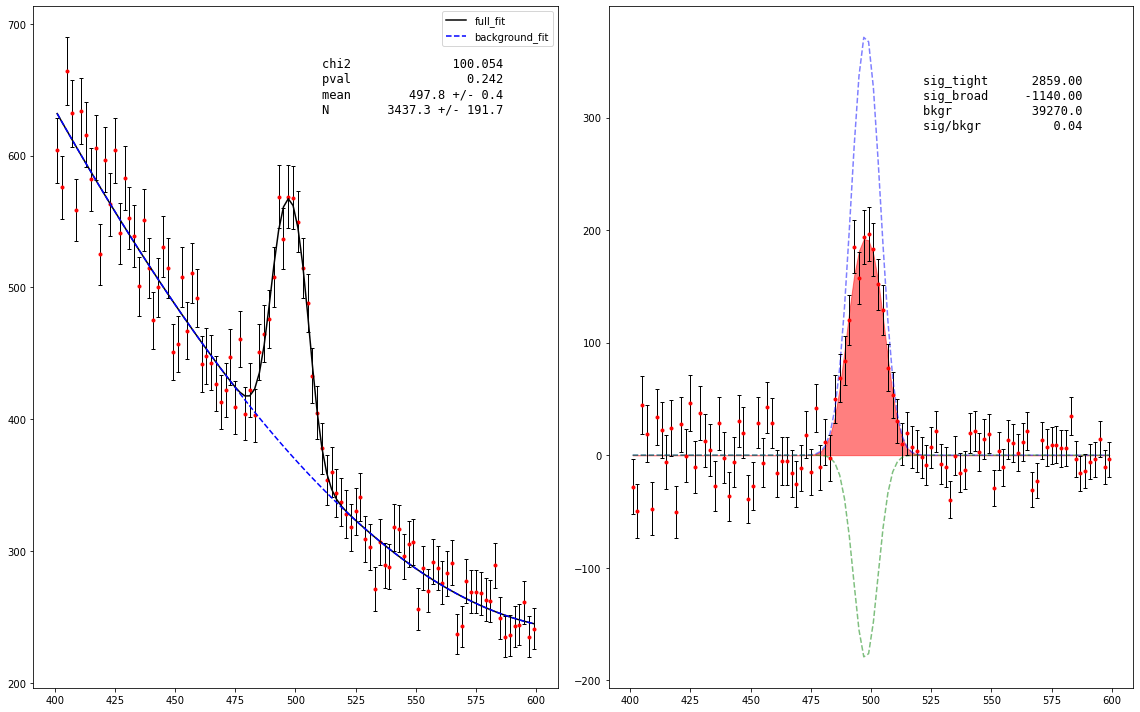

In [182]:
y, x, _ = hm.hist(data.v0_ks_mass, bins=100, range=(400,600))
fig, ax, fit, signal, bkgr = fit_mass_double(x, y, np.sqrt(y), guesses_sig=[498.9, 6, 20000])

(497.8331140443374, 5.574428599005612)

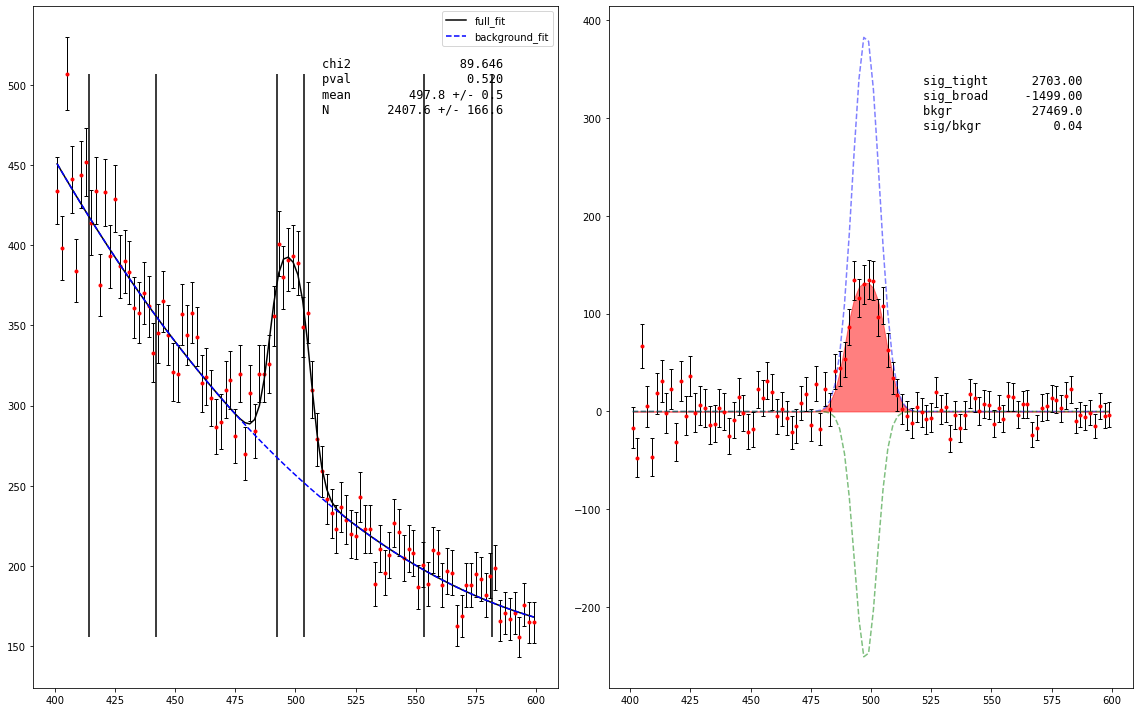

In [183]:
y, x, _ = hm.hist(train_data.v0_ks_mass,bins=100, range=(400,600))
fig, ax, M, sig, bkgr = fit_mass_double(x,y,np.sqrt(y), guesses_bkgr = [0, 0, -10, 2000], guesses_sig = [498, 6, 20000])
mean, sigma = M.values['mean'], M.values['sig']
signal = train_data.loc[(train_data.v0_ks_mass > mean - sigma) & (train_data.v0_ks_mass < mean + sigma)]
bkgr_l = train_data.loc[(train_data.v0_ks_mass > mean - 15*sigma) & (train_data.v0_ks_mass < mean - 10*sigma)]
bkgr_r = train_data.loc[(train_data.v0_ks_mass > mean + 10*sigma) & (train_data.v0_ks_mass < mean + 15*sigma)]
ax[0].vlines([mean-sigma,mean+sigma,mean-15*sigma,mean-10*sigma,mean+10*sigma,mean+15*sigma],min(y),max(y))

min_sample = min([len(signal),len(bkgr_l),len(bkgr_r)])
if min_sample != len(signal):print("WARNING! decrease background sample size or increase signal sample size")


train_data_cut = pd.concat([signal.sample(min_sample),
                   bkgr_l.sample(min_sample),
                   bkgr_r.sample(min_sample)])
train_data_cut['y'] = np.append(np.ones(min_sample),[np.zeros(min_sample),np.zeros(min_sample)])
mean, sigma

In [184]:
mass_true=train_data_cut.loc[train_data_cut.y==1]
mass_false=train_data_cut.loc[train_data_cut.y==0]

In [186]:
model_XG=XGBClassifier()
setattr(model_XG, 'verbosity', 1)
model_XG.fit(train_data_cut[uncorrelated],y=train_data_cut.y)

XGBClassifier()

In [187]:
p_XG = model_XG.predict_proba(test_data[uncorrelated])[:,1]

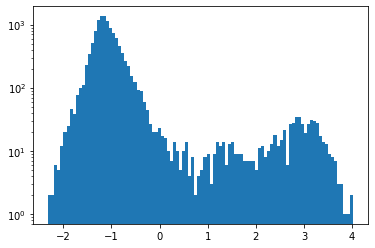

In [188]:
plt.hist(hm.logit(p_XG), bins=100)
plt.yscale('log')

Text(0.5, 0.98, 'Comparison of data and MC for v0_ks_mass')

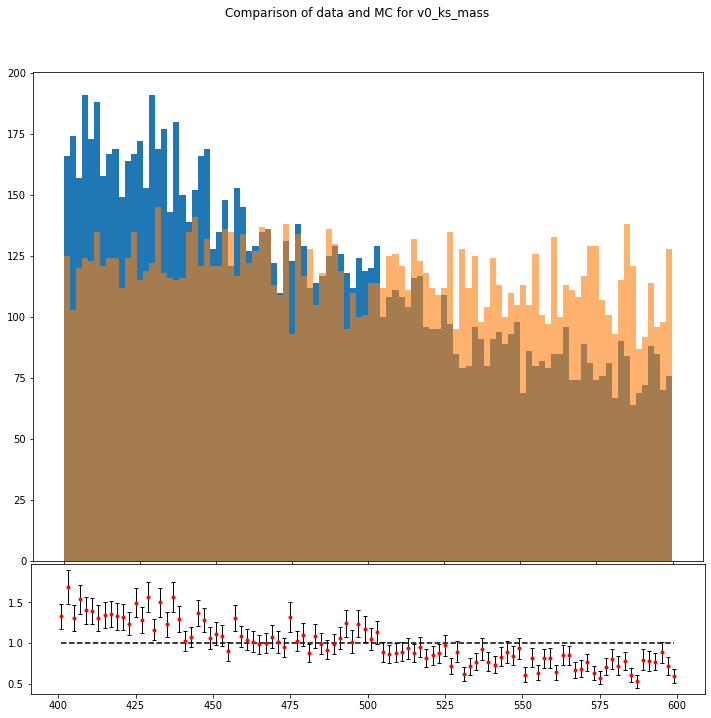

In [189]:
true=p_XG>0.8
k=1
L=len(test_data[~true])
col=test_data.columns[k]
fig, ax = plt.subplots(figsize=(12,9))
valsdat,binedges,_=ax.hist(test_data[~true].v0_ks_mass.sample(n=L), bins=100);
valsmc,_,_=ax.hist(mc.loc[mc.trueKs==0].v0_ks_mass.sample(n=L),bins=100, alpha=0.6);
errdat, errmc = np.sqrt(valsdat), np.sqrt(valsmc) 
bc=(binedges[:-1]+binedges[1:])/2
#left, bottom, width, height
ax2 = fig.add_axes([0.122,-0.08, 0.78,0.2]) 
errs=np.sqrt(errmc**2*valsdat**2/valsmc**4+(errdat*1/valsmc)**2)
vals=valsdat/valsmc
ax2.plot(bc, vals, 'r.', label='median')
ax2.errorbar(bc, vals, errs, color = 'k', elinewidth = 1, capsize = 2, ls = 'none')
ax2.hlines(1, min(bc), max(bc), linestyle='dashed')
fig.suptitle('Comparison of data and MC for v0_ks_mass')

invalid value encountered in true_divide
divide by zero encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


Text(0.5, 0.98, 'Comparison of data and MC for v0_ks_mass')

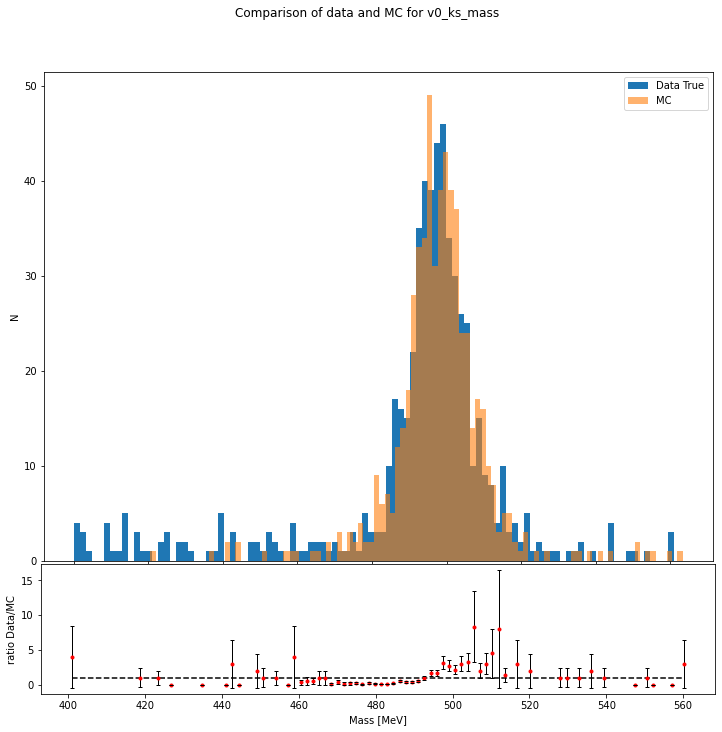

In [190]:
true=p_XG<0.8
k=1
L=len(test_data[~true])
col=test_data.columns[k]
fig, ax = plt.subplots(figsize=(12,9))
valsdat,binedges,_=ax.hist(test_data[~true].v0_ks_mass.sample(n=L), bins=100, label='Data True');
valsmc,_,_=ax.hist(mc.loc[mc.trueKs==1].v0_ks_mass.sample(n=L),bins=100, alpha=0.6, label='MC');
errdat, errmc = np.sqrt(valsdat), np.sqrt(valsmc) 
bc=(binedges[:-1]+binedges[1:])/2
#left, bottom, width, height
ax2 = fig.add_axes([0.122,-0.08, 0.78,0.2]) 
errs=np.sqrt(errmc**2*valsdat**2/valsmc**4+(errdat*1/valsmc)**2)
vals=valsdat/valsmc
ax2.plot(bc, vals, 'r.', label='median')
ax2.errorbar(bc, vals, errs, color = 'k', elinewidth = 1, capsize = 2, ls = 'none')
ax2.hlines(1, min(bc), max(bc), linestyle='dashed')
ax2.set(xlabel='Mass [MeV]', ylabel='ratio Data/MC')
ax.set(ylabel='N')
ax.legend()
fig.suptitle('Comparison of data and MC for v0_ks_mass')


# General comparison code (unclassified data with MC)

In [191]:
def compare(var='v0_ks_mass', td=test_data, MC=mc, true='trueKs', binL=100):
    L=len(td[var])
    MC=MC.sample(n=L)
    peak=MC.loc[mc[true]==1]
    bkg=MC.loc[mc[true]==0]
    fig, ax = plt.subplots(figsize=(12,9))
    valsdat,binedges,_=ax.hist(td[var], bins=binL, label='Data');
    valsmc,_,_=ax.hist(MC[var],bins=binL, alpha=0.8, label='MC signal');
    valsmcback,_,_=ax.hist(bkg[var],bins=binL, alpha=0.5, label='MC background');
    errdat, errmc = np.sqrt(valsdat), np.sqrt(valsmc) 
    bc=(binedges[:-1]+binedges[1:])/2
    ax.legend()
    ax.set(xlabel=var, ylabel='')
#     left, bottom, width, height
    ax2 = fig.add_axes([0.122,-0.08, 0.78,0.2]) 
    errs=np.sqrt(errmc**2*valsdat**2/valsmc**4+(errdat*1/valsmc)**2)
    vals=valsdat/valsmc
    chi2=vals**2/errs**2
    ax2.plot(bc, vals, 'r.', label='median')
    ax2.errorbar(bc, vals, errs, color = 'k', elinewidth = 1, capsize = 2, ls = 'none')
    ax2.hlines(1, min(bc), max(bc), linestyle='dashed')
    ax2.set(xlabel=var, ylabel='ratio Data/MC')
    
    text_a = {'chi2, Ndof': (np.sum(chi2),binL) }

    text_output = nice_string_output(text_a, decimals = 2)
    add_text_to_ax(0.60, 0.90, text_output, ax2, fontsize=10)
    ax.set(ylabel='N')
    fig.suptitle(f'Comparison of data and MC for {var}')
    ax.legend()
    fig, ax = plt.subplots(figsize=(12,9))
    signalguess=valsdat-valsmcback
    errguess=np.sqrt(valsdat+valsmcback)
    ax.plot(bc, signalguess, 'r.')
    ax.errorbar(bc, signalguess, errguess, color = 'k', elinewidth = 1, capsize = 2, ls = 'none')
    ax.set(xlabel=var, ylabel='N', title=f'Guess for signal distribution in {var}')
    return np.sum(chi2)

5952.333013898337

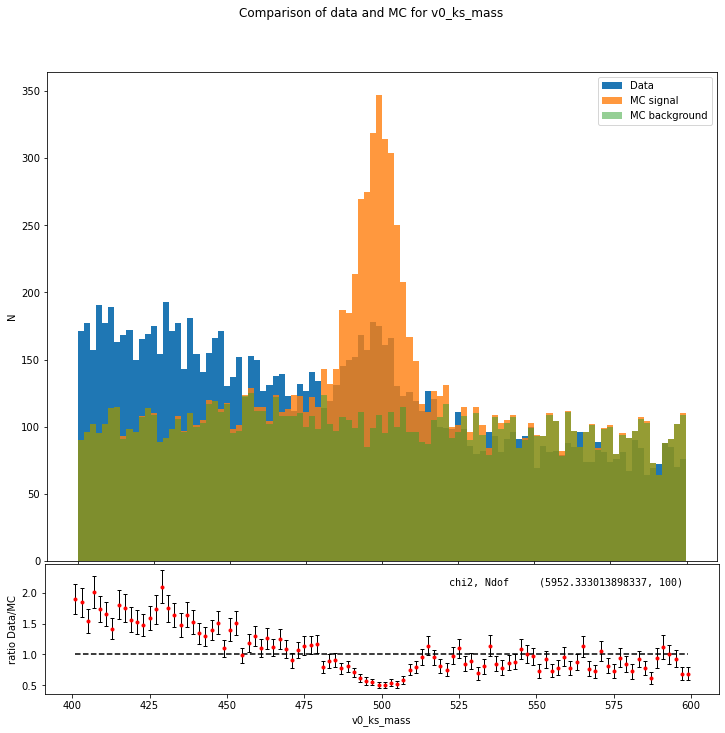

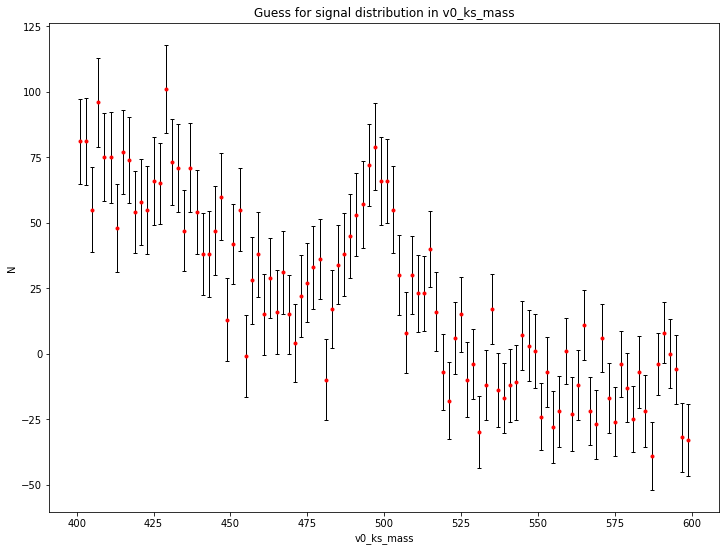

In [192]:
compare()

In [193]:
import hep_ml

In [194]:
import numpy
from hep_ml.reweight import BinsReweighter, GBReweighter
L=len(test_data.v0_ks_mass)
sWeights = numpy.ones(L)
original_weights = numpy.ones(L)
reweighter = BinsReweighter(n_bins=100, n_neighs=3)
sample=mc.sample(n=L)
reweighter.fit(original=sample.v0_ks_mass, target=test_data.v0_ks_mass,
                original_weight=original_weights)
MC_weights = reweighter.predict_weights(mc.v0_ks_mass[:L], original_weight=original_weights)
##The above is bins

In [22]:
model_XG_mc=XGBClassifier()
setattr(model_XG_mc, 'verbosity', 2)
model_XG_mc.fit(train_data_cut[train_data_cut.columns[2:-1]],y=train_data_cut.y)

[11:17:46] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[11:17:47] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[11:17:47] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[11:17:47] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[11:17:47] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[11:17:47] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[11:17:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[11:17:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:17:48] INFO: src/tree/updater_prune.cc:74: tree prun

KeyboardInterrupt: 

[11:17:52] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[11:17:52] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[11:17:52] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:17:53] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:17:53] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[11:17:53] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:17:53] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[11:17:53] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[11:17:53] INFO: src/tree/updater_prune.cc:74: tree pruning e

[11:18:08] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:18:08] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:18:08] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:18:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[11:18:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:18:09] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3


XGBClassifier(verbosity=2)

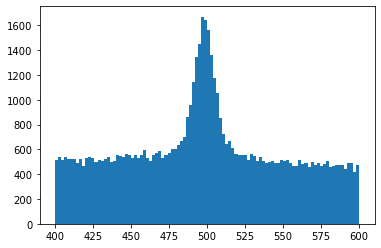

In [25]:
fig, ax = plt.subplots()
ax.hist(sample.v0_ks_mass, bins=100, weights=MC_weights);

v0_chi2
KS over  v0_chi2  =  0.0891817306251188
v0_px1
KS over  v0_px1  =  0.09707012238230904
v0_phi1
KS over  v0_phi1  =  0.034992980765754245
v0_py1
KS over  v0_py1  =  0.09977594590656258
v0_py
KS over  v0_py  =  0.12215470608117171
v0_py2
KS over  v0_py2  =  0.10330414055722426
v0_phi2
KS over  v0_phi2  =  0.038386338738468306
v0_px2
KS over  v0_px2  =  0.09777281750202604
v0_px
KS over  v0_px  =  0.11693930768650357
cosTheta
KS over  cosTheta  =  0.1948949992888589
a0xy
KS over  a0xy  =  0.2568151086953181
a0
KS over  a0  =  0.5099945081785141
v0_y
KS over  v0_y  =  0.1140041584849939
v0_x
KS over  v0_x  =  0.10467670245337274
v0_rxyErr
KS over  v0_rxyErr  =  0.13032551366132542
v0_z
KS over  v0_z  =  0.16497777239303066
pv0_z
KS over  pv0_z  =  0.3503287999053656
pv0_y
KS over  pv0_y  =  0.9998997672385088
ntrk_pv0
KS over  ntrk_pv0  =  0.46176243038068665
pv0_x
KS over  pv0_x  =  0.9999673967376346


invalid value encountered in true_divide


[0.0891817306251188,
 0.09707012238230904,
 0.034992980765754245,
 0.09977594590656258,
 0.12215470608117171,
 0.10330414055722426,
 0.038386338738468306,
 0.09777281750202604,
 0.11693930768650357,
 0.1948949992888589,
 0.2568151086953181,
 0.5099945081785141,
 0.1140041584849939,
 0.10467670245337274,
 0.13032551366132542,
 0.16497777239303066,
 0.3503287999053656,
 0.9998997672385088,
 0.46176243038068665,
 0.9999673967376346]

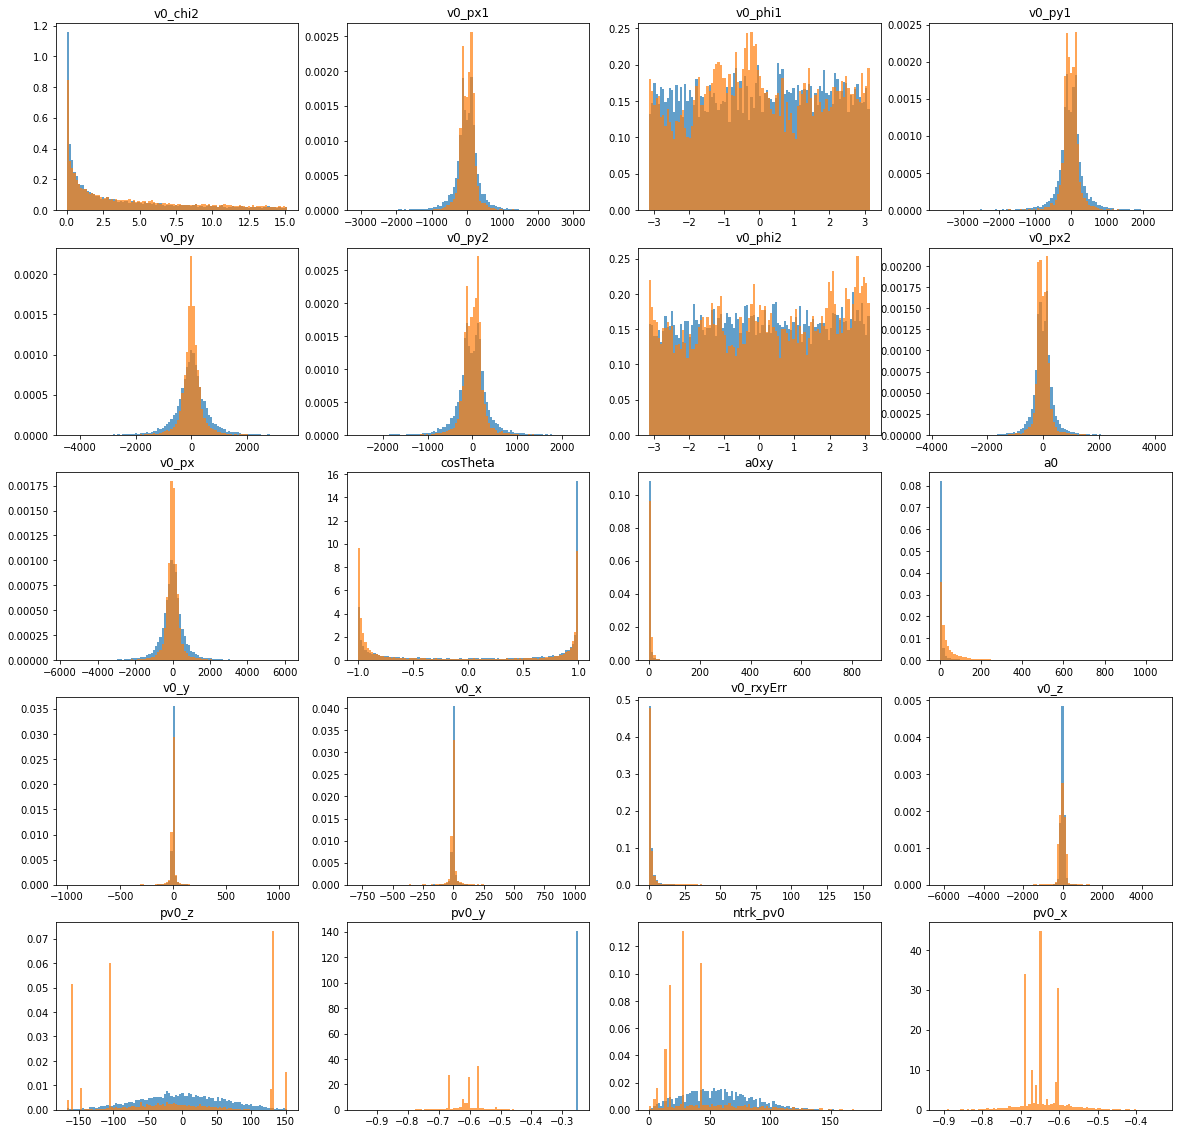

In [195]:
draw_distributions(sample[uncorrelated], test_data[uncorrelated], MC_weights)

# Better reweighing

In [196]:
from sklearn.model_selection import train_test_split
# divide MC samples into training and test parts
mc_train, mc_test = train_test_split(mc)
# divide target samples into training and test parts
data_train, data_test = train_test_split(data)

mcweights_train = numpy.ones(len(mc_train))
mcweights_test = numpy.ones(len(mc_test))

In [197]:
from hep_ml.metrics_utils import ks_2samp_weighted
hist_settings = {'bins': 100, 'density': True, 'alpha': 0.7}

def draw_distributions(original, target, new_original_weights):
    s=[]
    plt.figure(figsize=[20, 20])
    for id, column in enumerate(original.columns, 1):
        print(column)
        xlim = numpy.percentile(numpy.hstack([target[column]]), [0.01, 99.99])
        plt.subplot(5, 4, id)
        plt.hist(original[column], weights=new_original_weights, range=xlim, **hist_settings)
        plt.hist(target[column], range=xlim, **hist_settings)
        plt.title(column)
        print('KS over ', column, ' = ', ks_2samp_weighted(original[column], target[column], 
                                         weights1=new_original_weights, weights2=numpy.ones(len(target), dtype=float)))
        s.append(ks_2samp_weighted(original[column], target[column], 
                                         weights1=new_original_weights, weights2=numpy.ones(len(target), dtype=float)))
    return s

In [252]:
uncorrelated

array(['v0_chi2', 'v0_px1', 'v0_phi1', 'v0_py1', 'v0_py', 'v0_py2',
       'v0_phi2', 'v0_px2', 'v0_px', 'cosTheta', 'a0xy', 'a0', 'v0_y',
       'v0_x', 'v0_rxyErr', 'v0_z', 'pv0_z', 'pv0_y', 'ntrk_pv0', 'pv0_x'],
      dtype='<U9')

In [300]:
n=15
t=['pv0_z', 'pv0_y','pv0_x']
t=t[:1]
mtscaler=RobustScaler().fit(mc_train)
mc_train=mtscaler.transform(mc_train)

mtescaler=RobustScaler().fit(mc_test)
mc_test=mtescaler.transform(mc_test)

dtscaler=RobustScaler().fit(data_train)
data_train=dtscaler.transform(data_train)

dtescaler=RobustScaler().fit(data_test)
data_test=dtescaler.transform(data_test)
mask1=np.ones(16)
mask2=[1,0,1,1]
features=np.hstack((mask1, mask2))
s10o=draw_distributions(mc_train[features], data_train[features], mcweights_train)

IndexError: arrays used as indices must be of integer (or boolean) type

In [292]:
reweighter = GBReweighter()
reweighter.fit(mc_train[features], data_train[features])

GBReweighter(gb_args={})

v0_chi2
KS over  v0_chi2  =  0.0543071529689409
v0_px1
KS over  v0_px1  =  0.1074221246963335
v0_phi1
KS over  v0_phi1  =  0.03673325216372125
v0_py1
KS over  v0_py1  =  0.10946459682277754
v0_py
KS over  v0_py  =  0.1283997319570202
v0_py2
KS over  v0_py2  =  0.11636428540832089
v0_phi2
KS over  v0_phi2  =  0.06093467769689764
v0_px2
KS over  v0_px2  =  0.09930639621576212
v0_px
KS over  v0_px  =  0.10959143952109474
cosTheta
KS over  cosTheta  =  0.1652705014217732
a0xy
KS over  a0xy  =  0.13108180741810632
a0
KS over  a0  =  0.2672509254399051
v0_y
KS over  v0_y  =  0.06343136127275806
v0_x
KS over  v0_x  =  0.05557406259931086
v0_rxyErr
KS over  v0_rxyErr  =  0.09646907249241032
pv0_z
KS over  pv0_z  =  0.2628609988576526


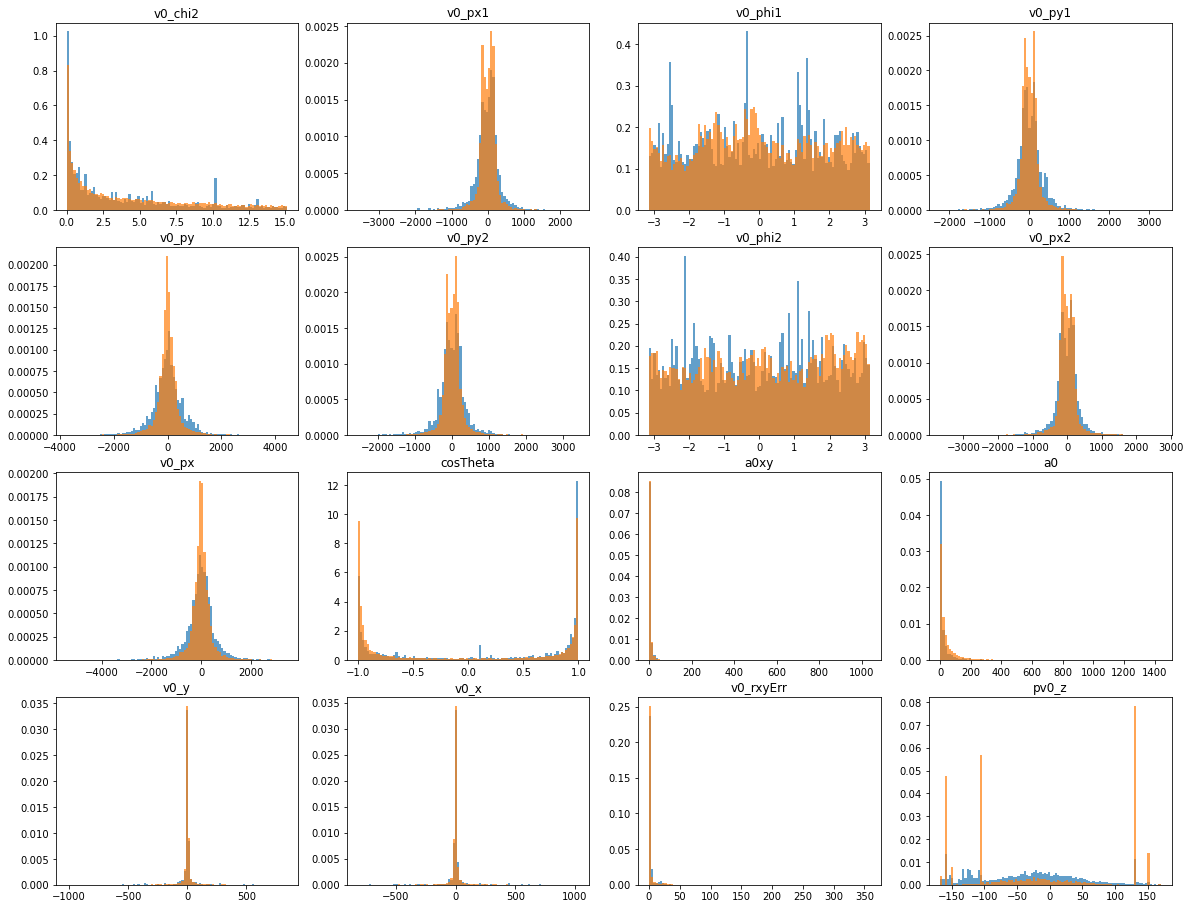

In [293]:
gb_weights_test = reweighter.predict_weights(mc_test[features])
# validate reweighting rule on the test part comparing 1d projections
s10=draw_distributions(mc_test[features], data_test[features], gb_weights_test)

In [290]:
if sum(s10o)/len(s10o)<np.sum(s10)/len(s10):
    print(f"{t}: WORSE", sum(s10o)/len(s10o),np.sum(s10)/len(s10))
else:
    print(f"{t}: BETTER", sum(s10o)/len(s10o),np.sum(s10)/len(s10))

['pv0_z', 'pv0_y', 'pv0_x']: WORSE 0.246509764653556 0.25708640433652274


In [277]:
uncorrelated1=['v0_chi2', 'v0_px1', 'v0_phi1', 'v0_py1', 'v0_py', 'v0_py2',
       'v0_phi2', 'v0_px2', 'v0_px', 'cosTheta', 'v0_y',
       'v0_x', 'v0_rxyErr', 'v0_z']

In [264]:
n=len(uncorrelated1)
reweighter = GBReweighter()
reweighter.fit(mc_train[uncorrelated1[:n]], data_train[uncorrelated1[:n]])
gb_weights_test = reweighter.predict_weights(mc_test[uncorrelated1[:n]])
# validate reweighting rule on the test part comparing 1d projections
draw_distributions(mc_test[uncorrelated1[:n]], data_test[uncorrelated1[:n]], gb_weights_test)

KeyboardInterrupt: 

In [177]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
# divide MC samples into training and test parts
mcs_train1, mcs_test1 = train_test_split(mc, train_size=0.7, random_state=420)
mcs_train_true, mcs_test_true=mcs_train1.trueKs, mcs_test1.trueKs 
datas_train1, datas_test1 = train_test_split(data, train_size=0.7, random_state=420)
transformmctrain=RobustScaler().fit(mcs_train1[uncorrelated])
mcs_train=transformmctrain.transform(mcs_train1[uncorrelated])
transformmctest=RobustScaler().fit(mcs_test1[uncorrelated])
mcs_test=transformmctest.transform(mcs_test1[uncorrelated])

transformdatatrain=RobustScaler().fit(datas_train1[uncorrelated])
datas_train=transformdatatrain.transform(datas_train1[uncorrelated])
transformdatatest=RobustScaler().fit(datas_test1[uncorrelated])
dtas_test=transformdatatest.transform(datas_test1[uncorrelated])

mcs_train=pd.DataFrame(mcs_train, columns=uncorrelated)
mcs_train['v0_chi2']=mcs_train1.v0_chi2.to_numpy()
mcs_train['cosTheta']=mcs_train1.cosTheta.to_numpy()

mcs_test=pd.DataFrame(mcs_test, columns=uncorrelated)
mcs_test['v0_chi2']=mcs_test1.v0_chi2.to_numpy()
mcs_test['cosTheta']=mcs_test1.cosTheta.to_numpy()

datas_train=pd.DataFrame(datas_train, columns=uncorrelated)
datas_train['v0_chi2']=datas_train1.v0_chi2.to_numpy()
datas_train['cosTheta']=datas_train1.cosTheta.to_numpy()

mcs_test=pd.DataFrame(mcs_test, columns=uncorrelated)
mcs_test['v0_chi2']=mcs_test1.v0_chi2.to_numpy()
mcs_test['cosTheta']=mcs_test1.cosTheta.to_numpy()

mcweights_train = numpy.ones(len(mcs_train))
mcweights_test = numpy.ones(len(mcs_test))

v0_chi2
KS over  v0_chi2  =  0.08112586547019185
v0_px1
KS over  v0_px1  =  0.05182779322212422
v0_phi1
KS over  v0_phi1  =  0.009989720244123812
v0_py1
KS over  v0_py1  =  0.049473991942198425
v0_py
KS over  v0_py  =  0.01268905302721679
v0_py2
KS over  v0_py2  =  0.04219349619223012
v0_phi2
KS over  v0_phi2  =  0.024245590493924052
v0_px2
KS over  v0_px2  =  0.04851056582957171
v0_px
KS over  v0_px  =  0.014693116825321484
cosTheta
KS over  cosTheta  =  0.1505021223935899
a0xy
KS over  a0xy  =  0.25560923055545176
a0
KS over  a0  =  0.21472036320912616
v0_y
KS over  v0_y  =  0.01656010157827259
v0_x
KS over  v0_x  =  0.015001610937421916
v0_rxyErr
KS over  v0_rxyErr  =  0.0342874535880901
v0_z
KS over  v0_z  =  0.02237595499517822
pv0_z
KS over  pv0_z  =  0.10440549270091622
pv0_y
KS over  pv0_y  =  0.12917223290462398
ntrk_pv0
KS over  ntrk_pv0  =  0.1774680560500524
pv0_x
KS over  pv0_x  =  0.09541037168252064


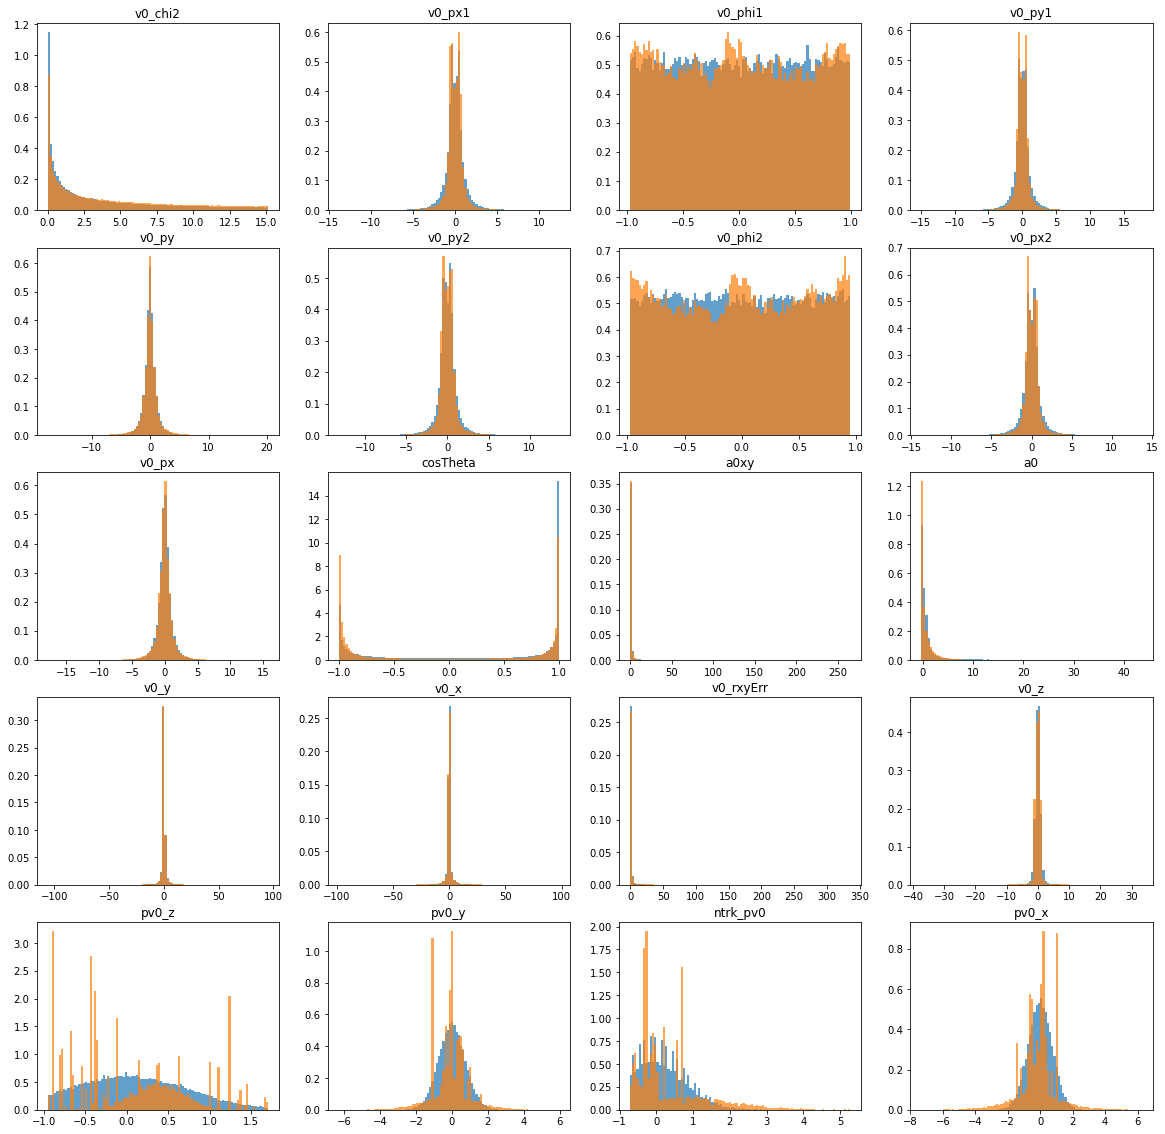

In [178]:
sorig=draw_distributions(mcs_train, datas_train, mcweights_train)

v0_chi2
KS over  v0_chi2  =  0.29918455520309933
v0_px1
KS over  v0_px1  =  0.4757440876059655
v0_phi1
KS over  v0_phi1  =  0.5000875776036431
v0_py1
KS over  v0_py1  =  0.5364420138957706
v0_py
KS over  v0_py  =  0.3623910894956967
v0_py2
KS over  v0_py2  =  0.36873560032612607
v0_phi2
KS over  v0_phi2  =  0.30648430216419165
v0_px2
KS over  v0_px2  =  0.4808026564837504
v0_px
KS over  v0_px  =  0.36626591570332223
cosTheta
KS over  cosTheta  =  0.8040905143361974
v0_y
KS over  v0_y  =  0.6071396853717557
v0_x
KS over  v0_x  =  0.4955385759586353
v0_rxyErr
KS over  v0_rxyErr  =  0.9826888270439637
v0_z
KS over  v0_z  =  0.5891668149679494


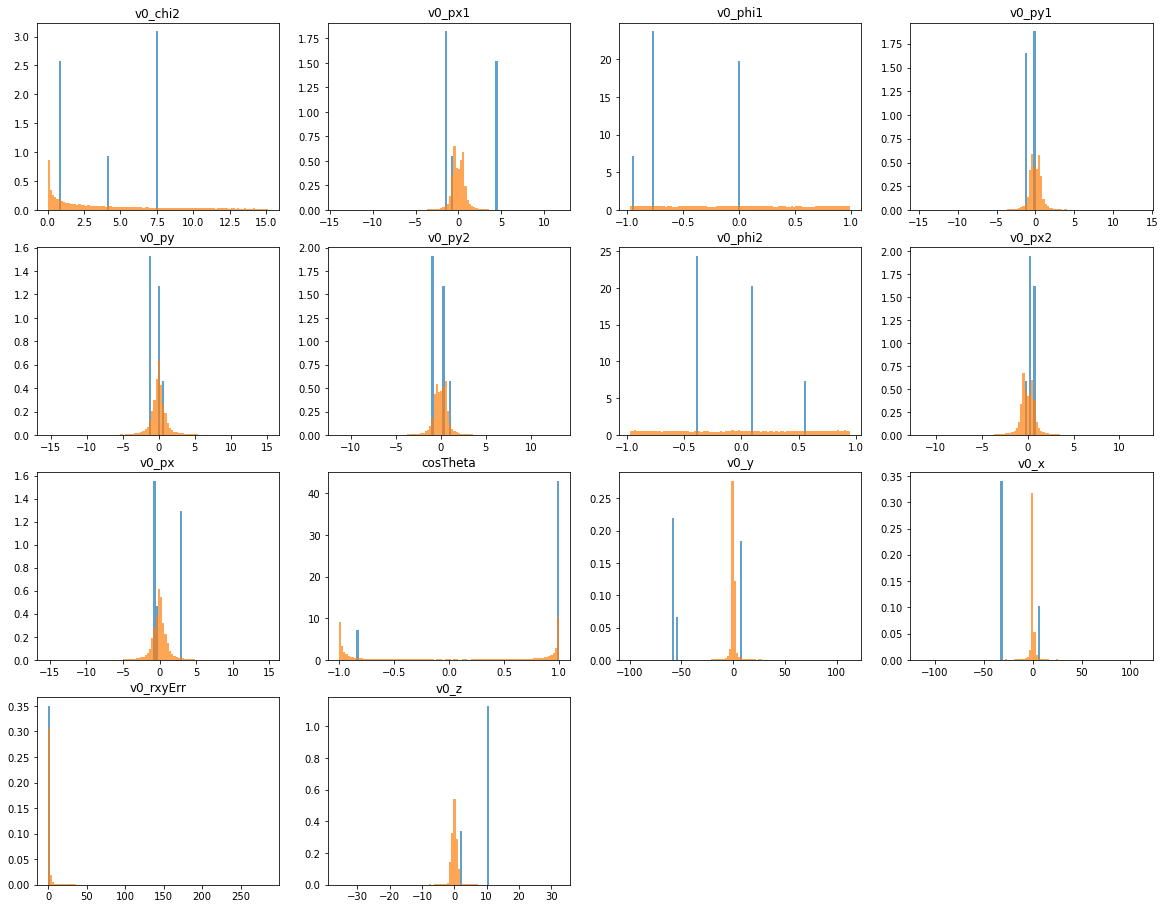

In [179]:
uncorrelated1=['v0_chi2', 'v0_px1', 'v0_phi1', 'v0_py1', 'v0_py', 'v0_py2',
       'v0_phi2', 'v0_px2', 'v0_px', 'cosTheta', 'v0_y',
       'v0_x', 'v0_rxyErr', 'v0_z']
reweighter = GBReweighter()
reweighter.fit(mcs_train[uncorrelated1], datas_train[uncorrelated1])
gb_weights_test = reweighter.predict_weights(mcs_test[uncorrelated1])
# validate reweighting rule on the test part comparing 1d projections
sweight=draw_distributions(mcs_test[uncorrelated1], datas_test[uncorrelated1], gb_weights_test)

In [171]:
uncorrelated, uncorrelated1, np.sum(sorig)/len(sorig), np.sum(sweight)/len(sweight)

(array(['v0_chi2', 'v0_px1', 'v0_phi1', 'v0_py1', 'v0_py', 'v0_py2',
        'v0_phi2', 'v0_px2', 'v0_px', 'cosTheta', 'a0xy', 'a0', 'v0_y',
        'v0_x', 'v0_rxyErr', 'v0_z', 'pv0_z', 'pv0_y', 'ntrk_pv0', 'pv0_x'],
       dtype='<U9'),
 ['v0_chi2',
  'v0_px1',
  'v0_phi1',
  'v0_py1',
  'v0_py',
  'v0_py2',
  'v0_phi2',
  'v0_px2',
  'v0_px',
  'cosTheta',
  'v0_y',
  'v0_x',
  'v0_rxyErr',
  'v0_z'],
 0.07736777384252773,
 0.6232372898746891)

In [174]:
import xgboost
eval_s = [(mcs_train[uncorrelated], mcs_train_true), (mcs_test[uncorrelated], mcs_test_true)]
# tsts.append(X_train)
model = xgboost.XGBClassifier(learning_rate = 0.02,n_estimators = 100)
model.fit(mcs_train[uncorrelated], mcs_train_true,verbose=True,eval_set=eval_s,early_stopping_rounds=30,eval_metric ="auc")

[0]	validation_0-auc:0.975271	validation_1-auc:0.975028
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.975313	validation_1-auc:0.975084
[2]	validation_0-auc:0.975944	validation_1-auc:0.97571
[3]	validation_0-auc:0.975817	validation_1-auc:0.975579
[4]	validation_0-auc:0.976048	validation_1-auc:0.975789
[5]	validation_0-auc:0.976604	validation_1-auc:0.97624
[6]	validation_0-auc:0.97667	validation_1-auc:0.976281
[7]	validation_0-auc:0.976822	validation_1-auc:0.976442
[8]	validation_0-auc:0.976957	validation_1-auc:0.976504
[9]	validation_0-auc:0.977035	validation_1-auc:0.976608
[10]	validation_0-auc:0.977412	validation_1-auc:0.976825
[11]	validation_0-auc:0.977402	validation_1-auc:0.976812
[12]	validation_0-auc:0.977474	validation_1-auc:0.976897
[13]	validation_0-auc:0.977519	validation_1-auc:0.976948
[14]	validation_0-auc:0.97758	validation_1-auc:0.97702
[15

XGBClassifier(learning_rate=0.02)

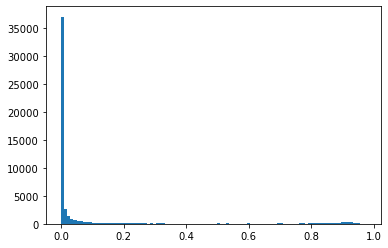

In [153]:
pxg=model.predict_proba(datas_test[uncorrelated1])[:,1]
plt.hist(pxg, bins=100);
# plt.yscale('log')

Completed fit with Chi2: 122.8, p-val: 0.015 and the total amount of signal 9977 +/- 168, background: 55495
Completed fit with Chi2: 92.3, p-val: 0.444 and the total amount of signal 9977 +/- 455, background: 54841
Completed fit with Chi2: 92.0, p-val: 0.452 and the total amount of signal 9479 +/- 204, background: 54684
Completed fit with Chi2: 92.0, p-val: 0.450 and the total amount of signal 8823 +/- 424, background: 54686
Completed fit with Chi2: 91.5, p-val: 0.465 and the total amount of signal 8212 +/- 257, background: 54642
Completed fit with Chi2: 89.6, p-val: 0.523 and the total amount of signal 7601 +/- 105, background: 54598
Completed fit with Chi2: 90.3, p-val: 0.502 and the total amount of signal 6961 +/- 184, background: 54584
Completed fit with Chi2: 90.3, p-val: 0.500 and the total amount of signal 6369 +/- 208, background: 54521
Completed fit with Chi2: 88.3, p-val: 0.559 and the total amount of signal 5821 +/- 144, background: 54415
Completed fit with Chi2: 87.8, p-val

Completed fit with Chi2: 94.5, p-val: 0.380 and the total amount of signal 595 +/- 177, background: 13156
Completed fit with Chi2: 94.1, p-val: 0.391 and the total amount of signal 650 +/- 180, background: 12445
Completed fit with Chi2: 97.2, p-val: 0.308 and the total amount of signal 946 +/- 169, background: 11494
Completed fit with Chi2: 99.4, p-val: 0.256 and the total amount of signal 886 +/- 158, background: 10899
Completed fit with Chi2: 102.0, p-val: 0.202 and the total amount of signal 935 +/- 181, background: 10197
Completed fit with Chi2: 105.9, p-val: 0.136 and the total amount of signal 748 +/- 385, background: 9728
Completed fit with Chi2: 103.5, p-val: 0.174 and the total amount of signal 404 +/- 186, background: 9418
Completed fit with Chi2: 108.8, p-val: 0.098 and the total amount of signal 386 +/- 216, background: 8781
Completed fit with Chi2: 104.3, p-val: 0.162 and the total amount of signal 335 +/- 168, background: 8177
Completed fit with Chi2: 102.0, p-val: 0.202 

-0.045567269160638184

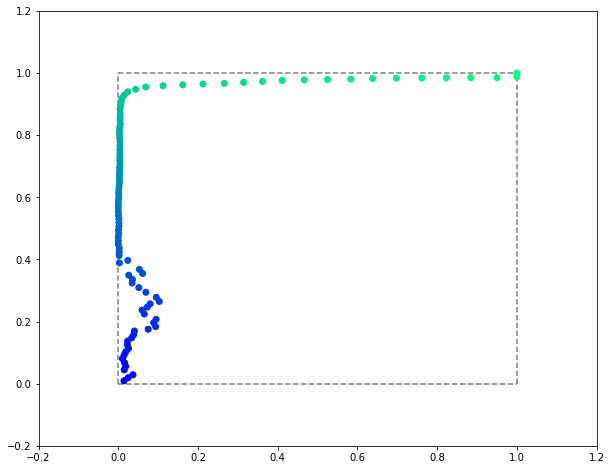

In [147]:
fig1, ax1=plt.subplots(figsize=(10,8))
hm.roc_curve_data(mcs_test1.v0_ks_mass, pxg, Npoints = 100, bins = 100, range = (400, 600), ax_roc = ax1 ,\
             verbose = True, plimit = 0.01)

In [154]:
true=pxg>0.7

In [155]:
eval_s = [(datas_train[uncorrelated1], datas_train[true]), (datas_test[uncorrelated1], datas_test[true])]
# tsts.append(X_train)
model = xgboost.XGBClassifier(learning_rate = 0.01,n_estimators = 1000)
model.fit(datas_train[uncorrelated1], mcs_train_true,verbose=True,eval_set=eval_s,early_stopping_rounds=30,eval_metric ="auc")

ValueError: Item wrong length 51383 instead of 154146.

In [ ]:
fig1, ax1=plt.subplots(figsize=(10,8))
hm.roc_curve_data(datas_test1.v0_ks_mass, pxg, Npoints = 20, bins = 100, range = (400, 600), ax_roc = ax1 ,\
             verbose = True, plimit = 0.01)